# DCMIP test case 4 demo - 3
-------

Here, the ability of the dynamical core to simulate a tropical cyclone is tested.

The main aim here is to simulate a tropical cyclone using a simple physics package 
(Reed and Jablonowski (2012)).

Jablonowski's group provides a fortran file which generates the initial conditions
to test any dynamical core. We have written a Cython wrapper around it, and use it to
start the simulation. We also have a wrapper around the simple physics package, which
provides the tendencies during each time step.

Using netCDF4 interface for IO
Lats, lons, levs, trunc, dims, tracers 190 384 28 126 8128 1
gfs_dynamics  can integrate  ['U', 'V', 'T', 'q', 'ps']
All fields integrated by federation members:  ['U', 'V', 'T', 'q', 'ps']
All fields returned by federation members:  ['U', 'V', 'T', 'q', 'ps', 'p', 'pint']


<IPython.core.display.Javascript object>


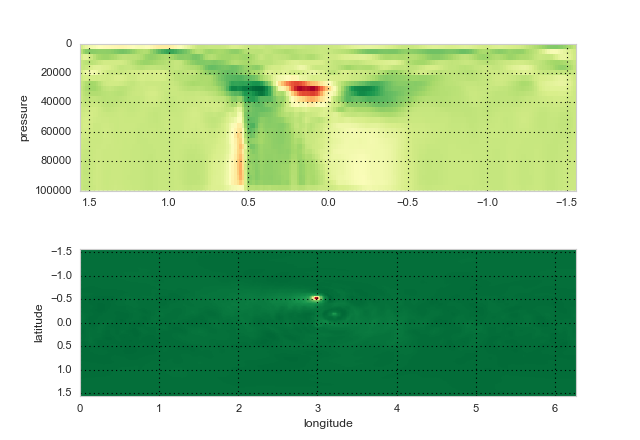

In [1]:
#%%file testSimple.py
%matplotlib notebook

from dynamics import dynamics
from dcmip import getTropicalCycloneICs
from simple_physics import simple_physics
from federation import federation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid',rc={'grid.linestyle':'dotted', 'grid.color':'0.0'})
# Dynamical core parameters
import matplotlib as mpl

mpl.rc('text', color='w')

kwargs = {}
kwargs['dt'] = 1200
kwargs['nlon'] = 384
kwargs['nlat'] = 190

#Init the dynamics Component
dycore = dynamics(scheme='gfs', **kwargs)

#Get the pressure and lat/lon values; this is needed
#to generate the initial conditions
pressure = dycore['p']
ps = dycore['ps']

full_latitudes = dycore.Extension.latitudes
full_longitudes = dycore.Extension.longitudes

#Get new initial conditions
u,v,t,q,phis,ps = getTropicalCycloneICs(pressure, full_longitudes, full_latitudes)
#Dynamical core expects virtual temperature
theta = t*(1+0.608*q)

#Initialise model topography
dycore.Extension.set_topography(phis)

#Initialise winds, surface pressure and temperature
dycore.Extension.initial_conditions(u,v,theta,ps,q)
dycore_grid = dycore.Grid
#Setup simple physics

kwargs['grid'] = dycore_grid
kwargs['dt'] = 1200
kwargs['U'] = u
kwargs['V'] = v
kwargs['T'] = t
kwargs['ps'] = ps
kwargs['pint'] = dycore['pint']

phys = simple_physics(**kwargs)

#Setup federation
kwargs = {}
kwargs['U'] = u
kwargs['V'] = v
kwargs['T'] = t
kwargs['ps'] = ps
kwargs['pint'] = dycore['pint']
kwargs['MonitorFields'] = ['U','ps'] # Display zonal velocity during simulation
kwargs['MonitorFreq'] = 1200.*3 #6 hourly update
kwargs['grid'] = dycore_grid

fed = federation(dycore, phys, **kwargs)


In [2]:

#Run the code for 10 days. each time step is 1200 seconds = 1/3 hour
num_steps = 10*24*3

p_min = np.zeros(num_steps)
for i in range(num_steps):
    #Go ahead one time step
    fed.step()
    p_min[i] = np.min(fed['ps'])

del(dycore)
del(fed)

<IPython.core.display.Javascript object>


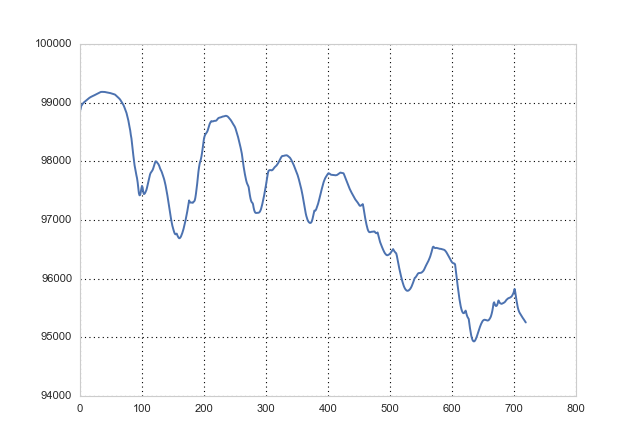

In [3]:
plt.figure()
plt.ioff()

plt.plot(p_min)
plt.show()